In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import sys
import os
import json
import itertools
import umap
from colour import Color
from collections import Counter
sys.path.insert(1, "../")
sys.path.insert(1, "../utilities")

from group_analysis import do_kmeans_clustering, plot_clusters, log_and_scale, colour_list, display_group_kw_combis
from helpers import load_posts, load_toks, load_pos, get_top_n_toks
from clustering import reduce_features, make_elbow_plot, compare_binary_normed_feature_embeddings, mc_list, plot_bin_and_norm_clusters, plot_contingency_matrix, calculate_cluster_lrs

from language_change_methods.features import get_tok_counts, function_words, combine_counts, make_feature_matrix
from language_change_methods.utility_functions import basic_preprocessing, get_ngram_example, get_text_example_of_pos, make_ngram_concordance, make_pos_concordance

from sklearn.cluster import KMeans, SpectralClustering, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

from nltk import ngrams as make_ngrams

from settings import TFES_FP as DB_FP, TFES_TOK_FP
GRAPH_DIR = "./Graphs"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%%time
all_posts = load_posts(DB_FP)

from helpers import flat_earth_boards, off_topic_boards as other_boards

fe_posts = all_posts.query("board_id in @flat_earth_boards")
ot_posts = all_posts.query("board_id in @other_boards")

toks = {int(x[0]): x[1] for x in load_toks(TFES_TOK_FP)}
toks = pd.Series(toks)
toks = toks[toks.index.isin(fe_posts.index)]

pos = {int(x[0]): x[1] for x in load_pos(TFES_TOK_FP)}
pos = pd.Series(pos)
pos = pos[pos.index.isin(fe_posts.index)]
pos = pos.loc[toks.index]

fe_posts = fe_posts.loc[toks.index]

Wall time: 31.1 s


In [4]:
with open("../data/user_metagroup.json") as group_file:
    meta_clusts = pd.Series(json.load(group_file))
    meta_clusts.index = meta_clusts.index.astype("float64")

In [5]:
post_lengths = toks.apply(len)
user_n_words = post_lengths.groupby(fe_posts["poster_id"]).sum()
posts_per_user = fe_posts.groupby("poster_id").size()

over_100 = posts_per_user[posts_per_user > 100]
print(f"{len(over_100)} with > 100 posts")

top_20 = posts_per_user.sort_values(ascending=False).head(20)
print(f"{len(top_20)} in the top 20")

curr_users = meta_clusts[meta_clusts == "Core Community"].index
    
user_n_words = user_n_words.loc[curr_users]
posts_per_user = posts_per_user.loc[curr_users]

curr_posts = fe_posts.query("poster_id in @curr_users")

# Get colour gradient
colour_gradient = list(Color("red").range_to(Color("blue"),len(curr_users)))
colour_gradient = pd.Series(colour_gradient, index=posts_per_user.loc[curr_users].sort_values(ascending=True).index)
colour_gradient = colour_gradient.loc[curr_users].apply(str)

101 with > 100 posts
20 in the top 20


# Create the user text chunks

In [6]:
merge_lists = lambda x: list(itertools.chain.from_iterable(x))

def get_chunks(u, tokens, chunk_size):
    for i in range(0, len(tokens)-chunk_size, chunk_size):
        yield u, tokens[i:i+chunk_size]

In [7]:
def make_tok_chonks(tokens, chunk_size):
    user_chunks = [[[user, chunk] for user, chunk in get_chunks(user, curr_toks, chunk_size)] for user, curr_toks in tokens.items()]
    user_chunks = merge_lists(user_chunks)
    user_chunks = pd.DataFrame(user_chunks, columns=["User", "Chunk"])
    return user_chunks

In [8]:
CHUNK_SIZE = 1000

In [9]:
%%time
user_toks = toks.groupby(curr_posts["poster_id"]).apply(merge_lists)
user_chunks = make_tok_chonks(user_toks, CHUNK_SIZE)

Wall time: 681 ms


In [10]:
%%time
user_pos = pos.groupby(curr_posts["poster_id"]).apply(merge_lists)
user_pos_chunks = make_tok_chonks(user_pos, CHUNK_SIZE)

Wall time: 1.05 s


# Create the Different Feature Counts

#### BOW

In [11]:
%%time
# Get the counts
bow_counts = {i: get_tok_counts(post) for i, post in user_toks.items()}
bow_counts = {i: {tok: count for tok, count in post.items() if tok not in function_words} for i, post in bow_counts.items()}
top_n = get_top_n_toks(bow_counts.values(), 10000)
bow_counts = {i: {tok: count for tok, count in post.items() if tok in top_n} for i, post in bow_counts.items()}
bow_counts = pd.Series(bow_counts)

Wall time: 35.1 s


#### Tfidf bow counts

In [12]:
%%time
# Credit for this cell: http://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/
from sklearn.feature_extraction.text import TfidfVectorizer
# If you had counts instead of tokens, you'd use "TfidfTransformer"

def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  


tfidf_matrix = tfidf.fit_transform(user_toks)

Wall time: 1.22 s


In [13]:
tfidf_feats = tfidf_matrix[:, np.isin(tfidf.get_feature_names(), top_n)].todense()

#### PoS Trigrams

In [14]:
pos_trigrams = pd.Series([make_ngrams(post, 3) for post in user_pos], index=user_pos.index)
pos_trigrams = pos_trigrams.apply(lambda post: ["_".join(words) for words in post])

In [15]:
top_n = [x[0] for x in Counter(merge_lists(pos_trigrams)).most_common(1000)]
pos_tri_counts = pos_trigrams.apply(Counter).apply(lambda dic: {w: c for w, c in dic.items() if w in top_n})
pos_tri_counts = pd.Series(pos_tri_counts)

In [16]:
# pos_tri_chunks = pd.DataFrame(index=user_pos_chunks.index)
# pos_tri_chunks["User"] = user_pos_chunks["User"]
# pos_tri_chunks["Chunk"] = pos_trigrams

# Create the Feature Matrix

In [17]:
%%time
# Initialise feats to None
bin_feats = None
norm_feats = None

# Make the feature matrix
curr_feat_type = "tfidf"
SCALE = True
APPLY_PCA = True

if curr_feat_type == "pos_tri":
    curr_counts = pos_tri_counts
    curr_toks = pos_trigrams
elif curr_feat_type == "bow":
    curr_counts = bow_counts
    curr_toks = user_toks
elif curr_feat_type == "tfidf":
    curr_counts = bow_counts
    curr_toks = user_toks
    bin_feats = np.vectorize(lambda x: 1 if x > 0 else 0)(tfidf_feats)
    norm_feats = tfidf_feats
    
if bin_feats is None:
    curr_feats, curr_feat_names = make_feature_matrix(curr_counts.to_dict(), False)
    bin_feats = np.vectorize(lambda x: 1 if x > 0 else 0)(curr_feats)
    norm_feats = curr_feats / user_toks.apply(len).values[:,None]

Wall time: 386 ms


#### Scaling

In [18]:
if SCALE:
    norm_feats = StandardScaler().fit_transform(norm_feats)

#### PCA reduction

In [19]:
%%time
from sklearn.decomposition import PCA
pca = PCA(.95)

if APPLY_PCA:
    norm_feats = pca.fit_transform(norm_feats)

Wall time: 413 ms


In [20]:
print(f"{norm_feats.shape[1]} components")

261 components


#### Make 2d embeddings

In [21]:
%%time
norm_embedding = reduce_features(norm_feats)

Wall time: 5.63 s


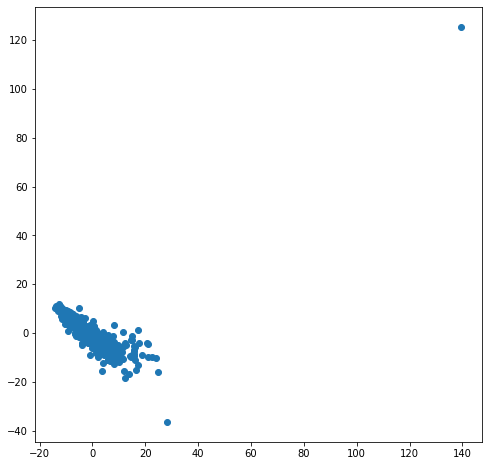

In [22]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(norm_feats[:,0], norm_feats[:,1])
plt.show()

# Do the Clustering

In [23]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cosine as cosine_dist
from sklearn.cluster import AgglomerativeClustering

In [24]:
def plot_hc(feats, labels, out_fp=None):
    # Perform the Hierarchical Clustering
    d_list = linkage(feats, 'average', metric="cosine")

    # Calculate the Cophenetic Correlation Coefficient
    c, coph_dists = cophenet(d_list, pdist(feats))
    print("Cophenetic Correlation Coefficient: {}".format(c))

    # Do the actual plotting.
    fig, ax = plt.subplots(figsize=(12,12))
    
    dendrogram(
        d_list,
        leaf_rotation=0,  # rotates the x axis labels
        leaf_font_size=14,  # font size for the x axis labels
        labels = labels, 
        ax=ax,
        color_threshold=0
    )
    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.set_xlabel("Users", fontsize=14)
    ax.set_ylabel("Cosine Distance", fontsize=14)
    ax.grid()
    
    plt.tight_layout()
    if out_fp is not None:
        fig.savefig(out_fp)

Cophenetic Correlation Coefficient: 0.3104616115777662


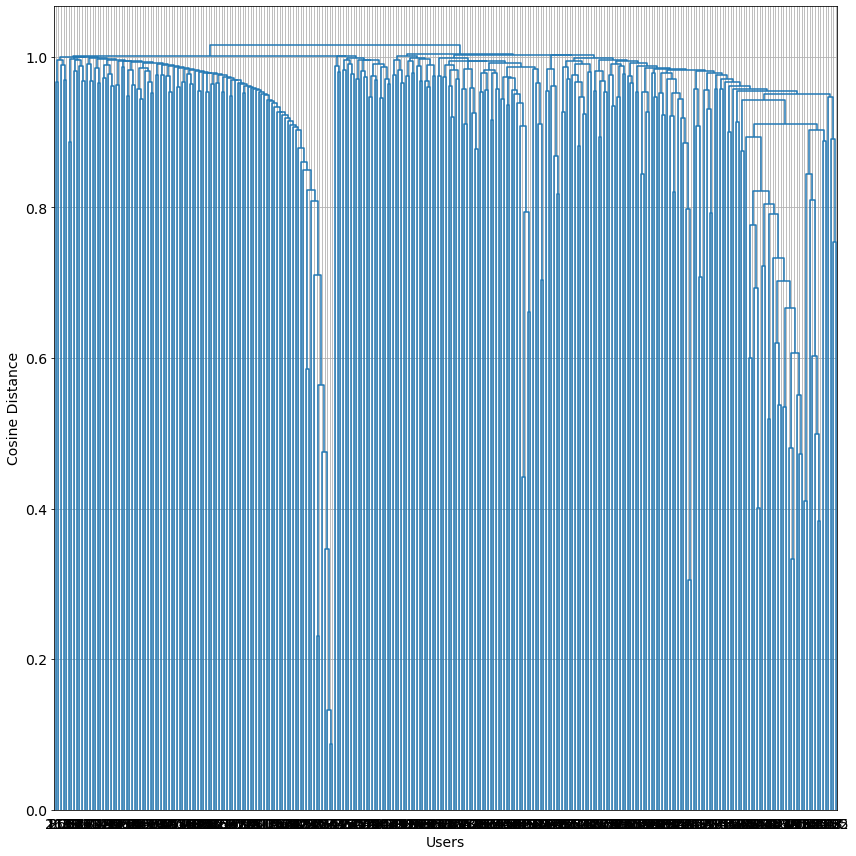

In [25]:
plot_hc(norm_feats, user_toks.index.astype(int), out_fp=None)#os.path.join(GRAPH_DIR, f"dendrogram_{curr_feat_type}.pdf"))

In [26]:
%%time
for i in range(2,10):
    model = AgglomerativeClustering(n_clusters=i, affinity='cosine', linkage='average')  
    clusters = model.fit_predict(norm_feats)
    avg_silhouette_score = metrics.silhouette_score(norm_feats, clusters, metric="cosine")
    print(f"Average silhoette score for {i} clusters:\t", avg_silhouette_score, "\n")

Average silhoette score for 2 clusters:	 0.0258861057710596 

Average silhoette score for 3 clusters:	 0.015978350980098647 

Average silhoette score for 4 clusters:	 0.016155027634349544 

Average silhoette score for 5 clusters:	 0.016132970261985312 

Average silhoette score for 6 clusters:	 0.015667075410915686 

Average silhoette score for 7 clusters:	 0.01517844011191553 

Average silhoette score for 8 clusters:	 0.014663518295954941 

Average silhoette score for 9 clusters:	 0.014464250669151893 

Wall time: 111 ms


In [27]:
%%time
sil_scores = []
for i in range(2,len(user_toks)):
    model = AgglomerativeClustering(n_clusters=i, affinity='cosine', linkage='average')  
    clusters = model.fit_predict(norm_feats)
    sil_scores.append(metrics.silhouette_score(norm_feats, clusters, metric="cosine"))

Wall time: 3.88 s


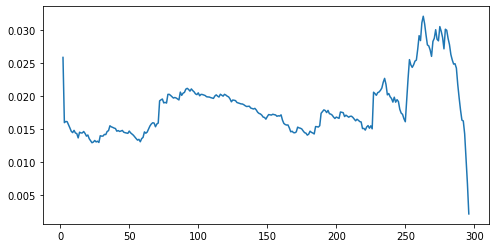

In [28]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(list(range(2, len(user_toks))), sil_scores)
plt.show()

In [29]:
model = AgglomerativeClustering(n_clusters=2, affinity='cosine', linkage='average')  
clusters1 = model.fit_predict(norm_feats)

In [30]:
for clust in set(clusters1):
    print(f"Num users in Cluster {clust}: {len(user_toks[clusters1==clust].index)}")

Num users in Cluster 0: 169
Num users in Cluster 1: 128


In [31]:
for clust in set(clusters1):
    print(f"Num words in Cluster {clust}: {len(merge_lists(user_toks[clusters1==clust]))}")

Num words in Cluster 0: 5722830
Num words in Cluster 1: 269008


In [32]:
for clust in set(clusters1):
    print(f"Avg words in Cluster {clust}: {user_toks[clusters1==clust].apply(len).mean():.0f}")
    print(f"Median words in Cluster {clust}: {user_toks[clusters1==clust].apply(len).median():.0f}")
    print()

Avg words in Cluster 0: 33863
Median words in Cluster 0: 12372

Avg words in Cluster 1: 2102
Median words in Cluster 1: 1155



In [33]:
model = AgglomerativeClustering(n_clusters=None, distance_threshold=1, affinity='cosine', linkage='average')  
clusters2 = model.fit_predict(norm_feats)

In [34]:
for clust in set(clusters2):
    print(f"Num users in Cluster {clust}: {len(user_toks[clusters2==clust].index)}")

Num users in Cluster 0: 106
Num users in Cluster 1: 41
Num users in Cluster 2: 19
Num users in Cluster 3: 105
Num users in Cluster 4: 6
Num users in Cluster 5: 12
Num users in Cluster 6: 5
Num users in Cluster 7: 3


In [35]:
for clust in set(clusters2):
    print(f"Num words in Cluster {clust}: {len(merge_lists(user_toks[clusters2==clust]))}")

Num words in Cluster 0: 146755
Num words in Cluster 1: 485762
Num words in Cluster 2: 102774
Num words in Cluster 3: 5058056
Num words in Cluster 4: 84742
Num words in Cluster 5: 59078
Num words in Cluster 6: 35192
Num words in Cluster 7: 19479


In [36]:
for clust in set(clusters2):
    print(f"Avg words in Cluster {clust}: {user_toks[clusters2==clust].apply(len).mean():.0f}")
    print(f"Median words in Cluster {clust}: {user_toks[clusters2==clust].apply(len).median():.0f}")
    print()

Avg words in Cluster 0: 1384
Median words in Cluster 0: 951

Avg words in Cluster 1: 11848
Median words in Cluster 1: 8204

Avg words in Cluster 2: 5409
Median words in Cluster 2: 4341

Avg words in Cluster 3: 48172
Median words in Cluster 3: 21031

Avg words in Cluster 4: 14124
Median words in Cluster 4: 9598

Avg words in Cluster 5: 4923
Median words in Cluster 5: 4858

Avg words in Cluster 6: 7038
Median words in Cluster 6: 5646

Avg words in Cluster 7: 6493
Median words in Cluster 7: 3722



In [37]:
clusters = clusters1

In [38]:
avg_silhouette_score = metrics.silhouette_score(norm_feats, clusters, metric="cosine")
print("Average silhoette score for Normed:\t", avg_silhouette_score, "\n")

Average silhoette score for Normed:	 0.0258861057710596 



In [39]:
for clust in set(clusters):
    print(clust, len(user_toks[clusters==clust].index))

0 169
1 128


In [40]:
print(",".join(map(str, user_toks[user_toks.index.isin(top_20.index)].index)))
print(",".join(map(str, clusters[user_toks.index.isin(top_20.index)])))

2.0,16.0,32.0,38.0,62.0,99.0,315.0,376.0,464.0,706.0,709.0,775.0,843.0,1206.0,1342.0,1423.0,1448.0,1500.0,1584.0,1804.0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
for i, (c1, c2) in enumerate(zip(clusters[user_toks.index.isin(top_20.index)], clusters2[user_toks.index.isin(top_20.index)])):
    print(i, c1, c2, sep=",")

0,0,3
1,0,3
2,0,3
3,0,3
4,0,1
5,0,3
6,0,3
7,0,3
8,0,3
9,0,3
10,0,3
11,0,3
12,0,3
13,0,3
14,0,3
15,0,3
16,0,3
17,0,3
18,0,3
19,0,3


In [42]:
ling_clusts = {"Cluster 0": list(user_toks[clusters1==0].index), 
               "Cluster 1": list(user_toks[clusters1==1].index)}

with open(os.path.join(GRAPH_DIR, f"{curr_feat_type}_core_clusts.json"), "w") as out_file:
    json.dump(ling_clusts, out_file)

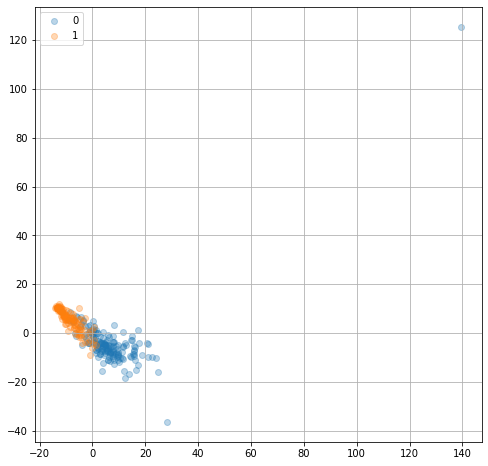

In [43]:
fig, ax = plt.subplots(figsize=(8,8))
for c in set(clusters):
    ax.scatter(norm_feats[clusters==c,0], norm_feats[clusters==c,1], label=c, alpha=0.3)
ax.grid()
ax.legend()
plt.show()

# Analyse Spread Across Users

In [44]:
user_toks.index[clusters==0]

Float64Index([   1.0,    2.0,    4.0,   14.0,   16.0,   18.0,   21.0,   26.0,
                27.0,   29.0,
              ...
              2167.0, 2195.0, 2207.0, 2218.0, 2222.0, 2223.0, 2236.0, 2243.0,
              2259.0, 2282.0],
             dtype='float64', name='poster_id', length=169)

In [45]:
user_toks.index[clusters==1]

Float64Index([   3.0,    5.0,    7.0,    9.0,   11.0,   15.0,   19.0,   20.0,
                23.0,   25.0,
              ...
              1991.0, 2003.0, 2007.0, 2010.0, 2015.0, 2022.0, 2023.0, 2105.0,
              2114.0, 2184.0],
             dtype='float64', name='poster_id', length=128)

In [46]:
contingency1 = pd.crosstab(user_toks.index.values, [clusters1], rownames=["User"], colnames=["Cluster"])
contingency2 = pd.crosstab(user_toks.index.values, [clusters2], rownames=["User"], colnames=["Cluster"])

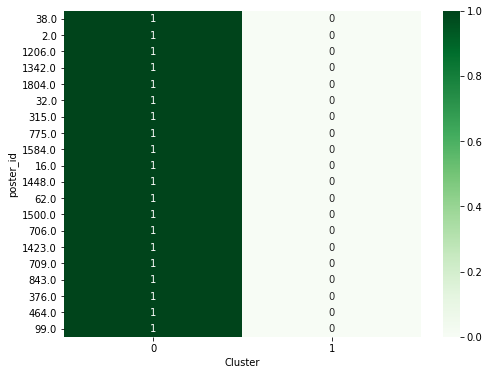

In [47]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(contingency1.loc[top_20.index], annot=True, ax=ax, fmt='g', cmap="Greens")
# fig.savefig(os.path.join(GRAPH_DIR, f"chunk_contingency_2_{curr_feat_type}.pdf"))
plt.show()

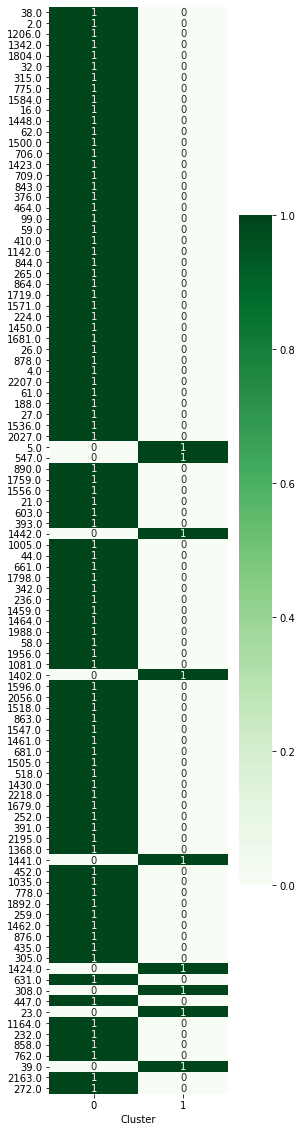

In [48]:
fig, ax = plt.subplots(figsize=(4,20))
sns.heatmap(contingency1.loc[posts_per_user.sort_values(ascending=False).head(100).index], annot=True, ax=ax, fmt='g', cmap="Greens")
# fig.savefig(os.path.join(GRAPH_DIR, f"chunk_contingency_2_{curr_feat_type}.pdf"))
plt.show()

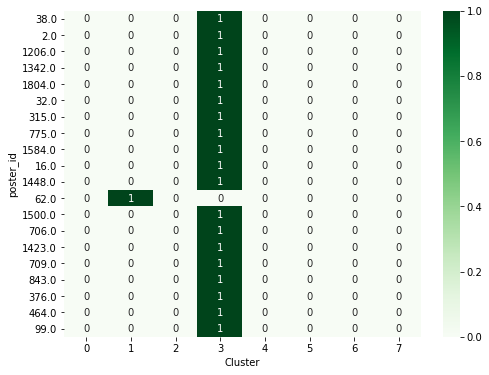

In [49]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(contingency2.loc[top_20.index], annot=True, ax=ax, fmt='g', cmap="Greens")
# fig.savefig(os.path.join(GRAPH_DIR, f"chunk_contingency_2_{curr_feat_type}.pdf"))
plt.show()

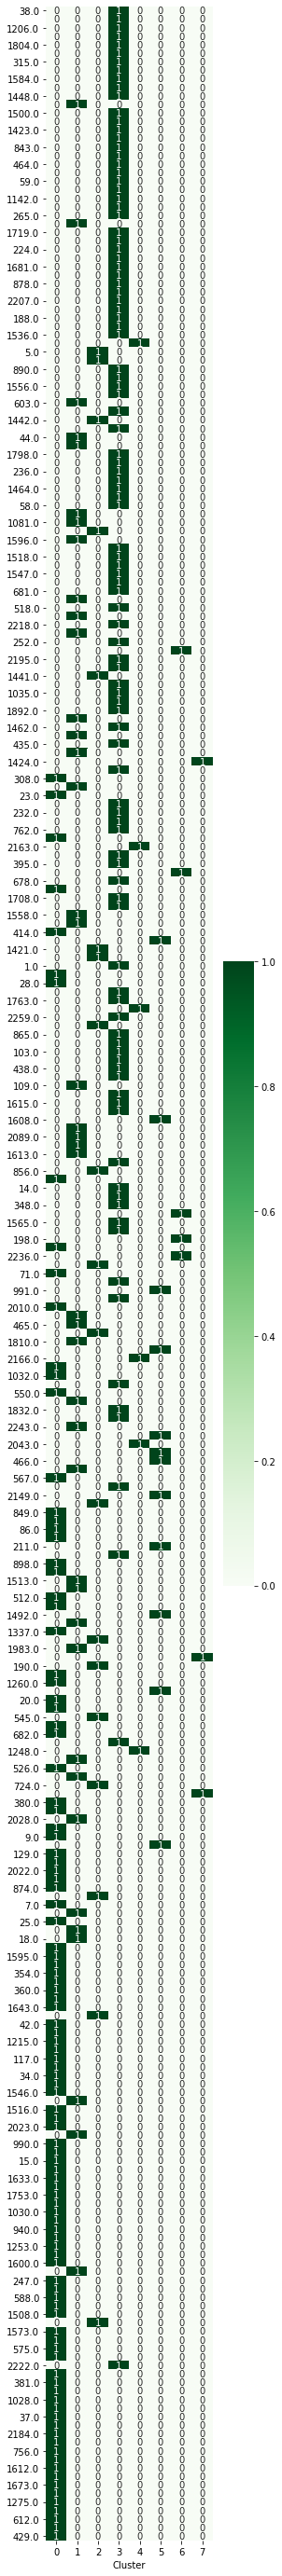

In [50]:
fig, ax = plt.subplots(figsize=(4,50))
sns.heatmap(contingency2.loc[posts_per_user.sort_values(ascending=False).index], annot=True, ax=ax, fmt='g', cmap="Greens")
# fig.savefig(os.path.join(GRAPH_DIR, f"chunk_contingency_2_{curr_feat_type}.pdf"))
plt.show()

# Compare clusters

In [51]:
clust_comparison = pd.crosstab(clusters1, [clusters2], rownames=["Clust 1"], colnames=["Clust 2"])

In [52]:
clust_comparison

Clust 2,0,1,2,3,4,5,6,7
Clust 1,,,,,,,,
0,0,41,0,105,6,12,5,0
1,106,0,19,0,0,0,0,3


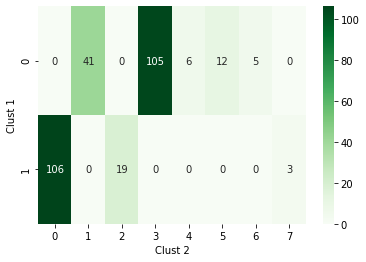

In [53]:
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(clust_comparison, annot=True, ax=ax, fmt='g', cmap="Greens")
plt.show()

# Get Some Keywords Between Clusters

In [54]:
%%time
lr = lambda x, y: np.log2(x / y)

def get_cluster_keywords(tokens, clusters):
    
    clust_counts = tokens.groupby(clusters).apply(
                    lambda x: [Counter(merge_lists(x))]).apply(
                    lambda x: x[0])
    clust_n_words = {clust: tokens[clusters==clust].apply(len).sum() for clust in set(clusters)}

    for clust, counts in clust_counts.items():
        other_counts = Counter(merge_lists(tokens[clusters!=clust]))
        other_nwords = tokens[clusters!=clust].apply(len).sum()
        lrs = calculate_cluster_lrs(counts, other_counts, clust_n_words[clust], other_nwords)
        lrs = {w: l for w, l in lrs.items() if counts[w] > 100}
        lrs = pd.Series(lrs).sort_values(ascending=False)
        t10_lr = lrs.head(20)
        b10_lr = lrs.tail(20)

        print(clust)
        print("-------------------------------------------------------------------------------------")
        for (w1, lr1), (w2, lr2) in zip(t10_lr.items(), b10_lr.items()):
            print(f"{w1:20}\t{lr1:10.2f}\t|\t{w2:20}\t{lr2:10.2f}")
        print("-------------------------------------------------------------------------------------")

Wall time: 0 ns


In [55]:
def get_cluster_lrs(tokens, clusters, min_freq=100):
    
    clust_counts = tokens.groupby(clusters).apply(
                    lambda x: [Counter(merge_lists(x))]).apply(
                    lambda x: x[0])
    clust_n_words = {clust: tokens[clusters==clust].apply(len).sum() for clust in set(clusters)}
    
    clust_kw = dict()

    for clust, counts in clust_counts.items():
        other_counts = Counter(merge_lists(tokens[clusters!=clust]))
        other_nwords = tokens[clusters!=clust].apply(len).sum()
        lrs = calculate_cluster_lrs(counts, other_counts, clust_n_words[clust], other_nwords)
        lrs = {w: l for w, l in lrs.items() if counts[w] > min_freq}
        lrs = pd.Series(lrs).sort_values(ascending=False)
   
        clust_kw[clust] = lrs
    return clust_kw

# Key features (2 clusters)

In [56]:
clusters = clusters1

## Key PoS-Trigrams

In [57]:
%%time
get_cluster_keywords(pos_trigrams, clusters)

0
-------------------------------------------------------------------------------------
NUM_ADP_PUNCT       	      3.50	|	DET_PRON_PUNCT      	     -1.21
CCONJ_PUNCT_X       	      3.48	|	NUM_NUM_ADP         	     -1.23
PROPN_NOUN_SYM      	      3.39	|	VERB_CCONJ_SCONJ    	     -1.26
VERB_PUNCT_X        	      2.49	|	PUNCT_INTJ_PRON     	     -1.27
NUM_PROPN_PUNCT     	      2.39	|	ADV_CCONJ_AUX       	     -1.29
SCONJ_PUNCT_DET     	      2.22	|	PRON_DET_AUX        	     -1.31
X_PUNCT_ADJ         	      2.21	|	ADP_DET_PRON        	     -1.33
PUNCT_X_DET         	      2.19	|	PRON_ADJ_PROPN      	     -1.36
CCONJ_ADJ_ADV       	      2.12	|	ADP_CCONJ_PRON      	     -1.37
X_X_PUNCT           	      2.04	|	PRON_INTJ_VERB      	     -1.40
ADJ_NUM_PUNCT       	      1.99	|	PUNCT_ADJ_VERB      	     -1.40
ADP_NUM_PROPN       	      1.92	|	INTJ_NOUN_PUNCT     	     -1.42
SYM_NOUN_NUM        	      1.92	|	AUX_PRON_INTJ       	     -1.43
PUNCT_PRON_PART     	      1.90	|	PUNCT_INTJ_DET      

In [58]:
get_text_example_of_pos(["NUM", "ADP", "PUNCT"], 
                        user_pos[clusters==0], 
                        user_toks[clusters==0], 
                        doc_labels=user_toks[clusters==0].index, n_examples=25)

Showing 25 out of 120:
2.0        m sure it 'll be easy for you to set one up ! yes , eric dubay hates people who di
2.0        hink you 're an idiot " , but rather one of " this is an unfortunate lose - lose s
2.0        . i guess your question requires for one to , by blind faith , assume that the fet
2.0        e is important - someone who 's made 10 off - topic posts today and was repeatedly
38.0       tar system . where are you getting 8000 from ? the erathostenes experiment interp
38.0       after sunrise netherlands reads 0.004 k w / kw and 15 minutes after sunrise austr
38.0       after sunrise netherlands reads 0.004 k w / kw and 15 minutes after sunrise austr
38.0       in which each country would try to " one up " each other with technological claims
38.0       iving translation translates isaiah 11:12 as : " he will raise a flag among the na
59.0       ard from the earth by 3.82 cm / yr ( 1.5 in / yr ) . however , this recession is h
59.0       t leads to two different equa

In [59]:
%%time
concs = make_pos_concordance(["NUM", "PROPN", "NUM"],
                             user_pos[clusters==1],
                             user_toks[clusters==1],
                             doc_labels=user_toks[clusters==1].index)
concs = pd.DataFrame(concs, columns=["user", "conc"])

print("Distribution across users:")
num_uses_per_user = concs.groupby("user").size()
print("Num uses per user", num_uses_per_user, sep="\n", end="\n\n")
print("Mean uses per user:\t", num_uses_per_user.mean())
print("Median uses per user:\t", num_uses_per_user.median())

Distribution across users:
Num uses per user
user
704.0     1
1253.0    7
1424.0    2
dtype: int64

Mean uses per user:	 3.3333333333333335
Median uses per user:	 2.0
Wall time: 62 ms


## Key words

In [60]:
%%time
get_cluster_keywords(user_toks, clusters)

0
-------------------------------------------------------------------------------------
sagnac              	      5.85	|	cancer              	     -1.66
drift               	      4.68	|	markjo              	     -1.66
scene               	      4.62	|	stuck               	     -1.67
numerical           	      4.53	|	clockwise           	     -1.69
repeatedly          	      4.48	|	troll               	     -1.69
motions             	      4.42	|	automatically       	     -1.71
geometric           	      4.42	|	2d                  	     -1.73
scripture           	      4.39	|	earther             	     -1.73
interactive         	      4.38	|	speculation         	     -1.74
drag                	      4.37	|	underneath          	     -1.77
â                	      4.35	|	lol                 	     -1.84
isnât            	      4.31	|	mr.                 	     -1.89
interferometer      	      4.26	|	wondering           	     -1.90
p                   	      4.22	|	upside              

In [61]:
%%time
clust_lrs = get_cluster_lrs(user_toks, clusters)

Wall time: 1.94 s


In [62]:
(clust_lrs[0]["re'ers"])

-0.8291312478938246

In [63]:
clust_lrs[0]["fe'ers"]

0.26922081069844817

In [64]:
clust_lrs[1]["flat"]

0.652166901298605

In [65]:
clust_lrs[1]["round"]

0.7784337767793472

In [66]:
c1 = len(make_ngram_concordance(["flat", "earthers"],
                                user_toks[clusters==0],
                                doc_labels=user_toks[clusters==0].index))

c2 = len(make_ngram_concordance(["flat", "earthers"],
                                user_toks[clusters==1],
                                doc_labels=user_toks[clusters==1].index))

n1 = user_toks[clusters==0].apply(len).sum()
n2 = user_toks[clusters==1].apply(len).sum()

print(f"Cluster 0: {c1} / {n1}")
print(f"Cluster 1: {c2} / {n2}")
lr((c1+0.5)/n1, (c2+0.5)/n2)

Cluster 0: 854 / 5722830
Cluster 1: 92 / 269008


-1.2034525475814108

In [67]:
c1 = len(make_ngram_concordance(["round", "earthers"],
                                user_toks[clusters==0],
                                doc_labels=user_toks[clusters==0].index))

c2 = len(make_ngram_concordance(["round", "earthers"],
                                user_toks[clusters==1],
                                doc_labels=user_toks[clusters==1].index))

n1 = user_toks[clusters==0].apply(len).sum()
n2 = user_toks[clusters==1].apply(len).sum()

print(f"Cluster 0: {c1} / {n1}")
print(f"Cluster 1: {c2} / {n2}")
lr((c1+0.5)/n1, (c2+0.5)/n2)

Cluster 0: 244 / 5722830
Cluster 1: 25 / 269008


-1.1497424557605003

In [68]:
get_ngram_example(["fe'ers"],
                  user_toks[clusters==0],
                  doc_labels=user_toks[clusters==0].index, n_examples=25)

Showing 25 out of 602:
2.0        ts in which " theory " may be used by fe'ers . within the context of " conspiracy 
2.0        s used in exactly the same fashion by fe'ers as other scientists , by way of provi
2.0        y be correct if he simply spoke to no fe'ers at all . personally , i propose that 
2.0        t large . that is not a claim serious fe'ers would make , in my humble opinion . p
2.0        ct and following the more influential fe'ers online . in other words : yes , but y
2.0        hat the most - supported map is among fe'ers . could you just go away now ? how do
2.0        uld be silly . rowbotham 's and other fe'ers ' experiments are reproducible . rabi
2.0        ised for some of the more belligerent fe'ers which appeared to target him at the t
2.0        ace in the few . yes , there are some fe'ers who are working on alternative models
2.0        olly , we sure showed those gosh darn fe'ers ! " engaging with them is an utter wa
2.0        gestions have garnered cri

In [69]:
get_ngram_example(["flat", "earthers"],
                  user_toks[clusters==0],
                  doc_labels=user_toks[clusters==0].index, n_examples=25)

Showing 25 out of 854:
2.0        er well . unfortunately , not all flat earthers are zeteticists , and we do have 
2.0         comments from round earthers and flat earthers alike , i would like to ask every
2.0         answering questions on behalf of flat earthers , especially if you 're going to 
2.0        . a bunch of the things you say " flat earthers " claim simply do not apply to th
2.0        ng something along the lines of " flat earthers claim that 2+2=5 and that is wron
2.0        ere , welcome to the forum . most flat earthers are primarily concerned with the 
2.0        nestly do n't think there are any flat earthers here who would claim california a
2.0        up a relatively small minority of flat earthers , very far from your alleged " al
2.0        way to carry on doing his thing . flat earthers ( or fe'ers for short ) is the mo
2.0        adbible ( click ) 21/08/2017 what flat earthers are saying about the total solar 
2.0         global news ( click ) 30/10/2017 fl

In [70]:
get_ngram_example(["dr"],
                  user_toks[clusters==1],
                  doc_labels=user_toks[clusters==1].index, n_examples=25)

Showing 25 out of 111:
23.0       eep the lie of a spherical earth . tl ; dr , but santa and satan use the same lett
28.0        exams to determine what is wrong . the dr does n't assume anything about my healt
28.0       eling alright 2 ) i reply feel fine 3 ) dr says ok you are perfectly healthy becau
35.0       a must reed ! how can you posibley deny dr . rowbothoms argumints ? try me well th
557.0       i disrespect you . ( credit to moose ) dr dre dispute here , can confirm the eart
1402.0     fell for it ? you need to stop typing " dr " in front of " rowbotham . " i think y
1402.0     botham ( note that i did not call him " dr rowbotham , " as he never received a do
1402.0     id . all right . whoever this made up " dr rowbotham " is might have done so in so
1421.0      to find any reference to him online as dr samuel rowbotham . are you sure about t
1442.0     mmets to levels humans ca n't survive . dr samuel rowbotham wrote : ' how far the 
1442.0     oldiers walking around the

# Key features (cosine dist < 1 clusters)

In [71]:
clusters = clusters2

In [72]:
%%time
get_cluster_keywords(pos_trigrams, clusters)

0
-------------------------------------------------------------------------------------
PROPN_AUX_ADJ       	      1.05	|	NOUN_PUNCT_NOUN     	     -0.36
PRON_ADP_PRON       	      0.74	|	PUNCT_PROPN_PROPN   	     -0.36
DET_PROPN_AUX       	      0.74	|	PUNCT_NOUN_PUNCT    	     -0.36
SCONJ_DET_PROPN     	      0.58	|	PROPN_PROPN_PUNCT   	     -0.37
VERB_PRON_AUX       	      0.57	|	ADJ_ADJ_NOUN        	     -0.37
ADV_AUX_PRON        	      0.54	|	PUNCT_CCONJ_PRON    	     -0.38
NOUN_CCONJ_PRON     	      0.52	|	DET_VERB_NOUN       	     -0.38
VERB_PRON_DET       	      0.50	|	VERB_PUNCT_CCONJ    	     -0.39
AUX_PRON_VERB       	      0.49	|	PUNCT_VERB_DET      	     -0.39
PUNCT_AUX_PRON      	      0.47	|	NOUN_NOUN_NOUN      	     -0.40
AUX_PART_DET        	      0.44	|	DET_PROPN_PUNCT     	     -0.42
PRON_DET_NOUN       	      0.44	|	NOUN_PUNCT_CCONJ    	     -0.43
AUX_ADJ_CCONJ       	      0.43	|	PUNCT_CCONJ_VERB    	     -0.43
PRON_VERB_PRON      	      0.41	|	PUNCT_DET_ADJ       

6
-------------------------------------------------------------------------------------
VERB_ADP_PRON       	      0.45	|	NOUN_PUNCT_ADV      	     -0.00
PUNCT_ADV_PUNCT     	      0.43	|	DET_NOUN_ADP        	     -0.02
VERB_PRON_NOUN      	      0.42	|	NOUN_AUX_VERB       	     -0.03
ADP_PRON_PUNCT      	      0.40	|	PRON_AUX_ADV        	     -0.03
ADP_ADJ_NOUN        	      0.38	|	VERB_DET_NOUN       	     -0.03
AUX_VERB_PRON       	      0.35	|	VERB_ADP_DET        	     -0.04
VERB_PRON_PUNCT     	      0.34	|	ADJ_NOUN_PUNCT      	     -0.04
PUNCT_CCONJ_PRON    	      0.33	|	PUNCT_PRON_AUX      	     -0.04
PRON_VERB_ADP       	      0.30	|	PUNCT_DET_NOUN      	     -0.05
NOUN_CCONJ_NOUN     	      0.30	|	PUNCT_SCONJ_PRON    	     -0.06
NOUN_PRON_VERB      	      0.29	|	DET_NOUN_AUX        	     -0.06
PRON_NOUN_PUNCT     	      0.29	|	DET_ADJ_NOUN        	     -0.07
ADV_DET_NOUN        	      0.27	|	VERB_DET_ADJ        	     -0.08
DET_NOUN_VERB       	      0.26	|	DET_NOUN_NOUN       

In [73]:
%%time
get_cluster_keywords(user_toks, clusters)

0
-------------------------------------------------------------------------------------
nt                  	      2.86	|	much                	     -0.20
forum               	      1.74	|	at                  	     -0.20
s                   	      1.03	|	by                  	     -0.22
claim               	      0.86	|	one                 	     -0.23
prove               	      0.81	|	different           	     -0.24
proof               	      0.78	|	've                 	     -0.25
flat                	      0.75	|	than                	     -0.26
am                  	      0.75	|	/                   	     -0.26
water               	      0.73	|	two                 	     -0.27
'm                  	      0.72	|	)                   	     -0.28
believe             	      0.67	|	(                   	     -0.29
me                  	      0.66	|	model               	     -0.39
saying              	      0.66	|	"                   	     -0.45
round               	      0.63	|	which               

6
-------------------------------------------------------------------------------------
other               	      0.79	|	or                  	     -0.06
moon                	      0.67	|	that                	     -0.06
my                  	      0.60	|	n't                 	     -0.06
sun                 	      0.49	|	"                   	     -0.07
all                 	      0.46	|	if                  	     -0.07
)                   	      0.45	|	you                 	     -0.09
can                 	      0.44	|	with                	     -0.14
?                   	      0.42	|	is                  	     -0.14
they                	      0.41	|	on                  	     -0.15
this                	      0.41	|	from                	     -0.16
see                 	      0.36	|	a                   	     -0.18
i                   	      0.32	|	there               	     -0.21
how                 	      0.31	|	-                   	     -0.21
as                  	      0.29	|	your                